# Recursive multi-step forecasting for categorical time series

Recursive multi-step forecasting is a technique used to predict future values in a time series by using previous predictions as inputs for subsequent forecasts. 

In the context of categorical time series, where the values belong to discrete categories rather than continuous values, the model is trained to predict the probability distribution over the possible categories for each future time step. The most likely category for the current time step is then used as input for predicting the next time step, and this process continues recursively.

Although the process is conceptually very similar to that used for continuous time series (https://skforecast.org/0.18.0/introduction-forecasting/introduction-forecasting), many challenges arise due the need to encode and decode categorical variables, as well as allowing the underlying machine learning model to handle categorical data effectively.

!TODO: add gift showing the recursive process for categorical time series

**Skforecast** provides the class `ForecasterRecursiveClassifier` to facilitate recursive multi-step forecasting for categorical time series, automatically managing the encoding and decoding of categorical variables, and integrating seamlessly with various machine learning models that support classification tasks.

## Libraries and data

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent.parent)
print(path)
sys.path.insert(1, path)

import skforecast
print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.19.0


In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeaturesClassification
from skforecast.recursive import ForecasterRecursiveClassifier
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster, bayesian_search_forecaster
from skforecast.plot import set_dark_theme

In [3]:
# Download dataset
# ==============================================================================
# TODO: move to skforecast.datasets
data = pd.read_csv("time_series_categorical.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data = data.asfreq('D')
data

,y
datetime,
2023-01-01,high
2023-01-02,low
2023-01-03,high
2023-01-04,high
2023-01-05,low
...,...
2024-12-26,low
2024-12-27,low
2024-12-28,low


In [4]:
# Split train-test
# ==============================================================================
end_train = '2024-07-30'
data_train = data[:end_train].copy()
data_test  = data[end_train:].copy()

print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 2023-01-01 00:00:00 --- 2024-07-30 00:00:00  (n=577)
Test dates  : 2024-07-30 00:00:00 --- 2024-12-30 00:00:00  (n=154)


## Plotting categorical time series

Visualizing categorical time series can be challenging due to the discrete nature of the data. Most of the standard plotting libraries require numerical inputs to create plots which means that categorical data needs to be encoded into numerical format for visualization purposes.

In [5]:
# Data preprocessing
# ==============================================================================
# Encode categorical variable as numerical for plotting
encode_mapping = {'low': 0, 'medium': 1, 'high': 2}
print(f"Encoding map: {encode_mapping}")
data['encoded_value'] = data['y'].map(encode_mapping)
data_train['encoded_value'] = data_train['y'].map(encode_mapping)
data_test['encoded_value'] = data_test['y'].map(encode_mapping)
data.head(3)

Encoding map: {'low': 0, 'medium': 1, 'high': 2}


,y,encoded_value
datetime,,
2023-01-01,high,2
2023-01-02,low,0
2023-01-03,high,2


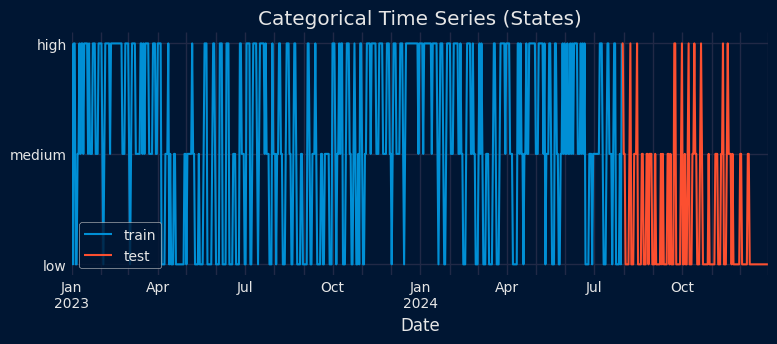

In [6]:
# Plot: line plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3))
data_train['encoded_value'].plot(ax=ax, label='train')
data_test['encoded_value'].plot(ax=ax, label='test')
y_ticks = list(encode_mapping.values())
y_labels = list(encode_mapping.keys())
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_title("Categorical Time Series (States)")
ax.set_xlabel("Date")
ax.legend();

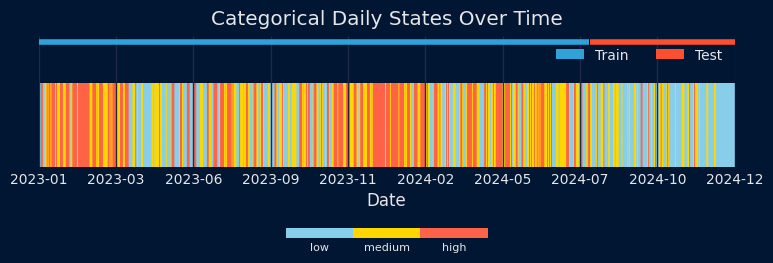

In [7]:
# Plot: 1-row heatmap-style scatter
# ==================================================================================================
colors = ["skyblue", "gold", "tomato"]
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 1, 2, 3], cmap.N)
stripe_height = 20
state_array = np.tile(data["encoded_value"].values, (stripe_height, 1))
train_mask = data.index <= pd.to_datetime(end_train)
train_indices = np.where(train_mask)[0]
test_indices = np.where(~train_mask)[0]

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(
    state_array,
    aspect="auto",
    cmap=cmap,
    norm=norm,
    extent=[0, len(data) - 1, 0, stripe_height],
)

ax.hlines(y=30, xmin=train_indices[0], xmax=train_indices[-1], color="#30a2da", linewidth=4)
ax.hlines(y=30, xmin=test_indices[0], xmax=test_indices[-1], color="#fc4f30", linewidth=4)
ax.set_yticks([])
ax.set_frame_on(False)
tick_indices = np.linspace(0, len(data) - 1, 10, dtype=int)
ax.set_xticks(tick_indices)
ax.set_xticklabels([data.index[i].strftime("%Y-%m") for i in tick_indices], rotation=0, ha="center")
ax.set_xlabel("Date")
ax.set_title("Categorical Daily States Over Time", pad=8)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    ticks=[0.5, 1.5, 2.5],
    pad=0.3,       # space between plot and colorbar
    fraction=0.05,  # thickness
    aspect=20       # length-to-height ratio
)
cbar.outline.set_visible(False)
cbar.ax.set_xticklabels(["low", "medium", "high"], fontsize=8)
cbar.set_label("", labelpad=2, fontsize=9)

legend_elements = [
    Patch(facecolor="#30a2da", label="Train"),
    Patch(facecolor="#fc4f30", label="Test"),
]
ax.legend(handles=legend_elements, loc="upper right", frameon=False, ncol=2, borderaxespad=0.5);

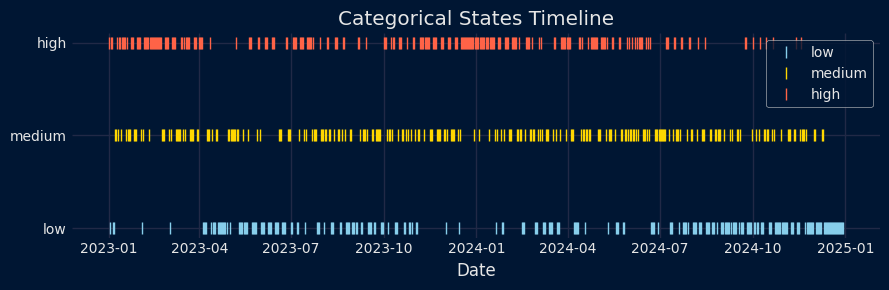

In [8]:
# Plot: states timeline
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3))
color_map = {"low": "skyblue", "medium": "gold", "high": "tomato"}
for state, color in color_map.items():
    mask = data["y"] == state
    ax.plot(data.index[mask], [state]*mask.sum(), '|', color=color, markersize=8, label=state)
ax.set_yticks(y_ticks)
ax.set_title("Categorical States Timeline")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


## Create and train forecaster

In [9]:
# Create and fit forecaster with rolling window features
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                 regressor         = LGBMClassifier(random_state=123, verbose=-1),
                 lags              = 14,
                 window_features   = RollingFeaturesClassification(stats=['proportion'], window_sizes=21),
                 features_encoding = 'auto', 
             )

forecaster.fit(y=data_train['y'])
forecaster

============================= 
ForecasterRecursiveClassifier 
============================= 
Classifier: LGBMClassifier 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window features: ['roll_proportion_21'] 
Window size: 21 
Series name: y 
Classes: ['high', 'low', 'medium'] 
Number of classes: 3 
Exogenous included: False 
Exogenous names: None 
Feature encoding: auto 
Transformer for exog: None 
Weight function included: False 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2024-07-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Classifier parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-11-02 15:15:55 
Last fit date: 2025-11-02 15:15:55 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

## Prediction

In [10]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
predictions

2024-07-31      high
2024-08-01      high
2024-08-02    medium
2024-08-03       low
2024-08-04       low
2024-08-05       low
2024-08-06    medium
Freq: D, Name: pred, dtype: object

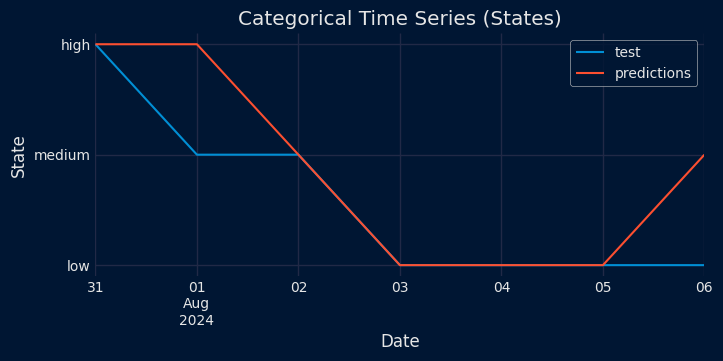

In [11]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test.loc[predictions.index, 'encoded_value'].plot(ax=ax, label='test')
predictions.to_frame().assign(encoded_value=predictions.map(encode_mapping))['encoded_value'].plot(ax=ax, label='predictions')
y_ticks = list(encode_mapping.values())
y_labels = list(encode_mapping.keys())
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_title("Categorical Time Series (States)")
ax.set_xlabel("Date")
ax.set_ylabel("State")
ax.legend();

In [12]:
# Prediction error
# ==============================================================================
error_mse = balanced_accuracy_score(
                y_true = data_test.loc[predictions.index, 'y'],
                y_pred = predictions
            )
print(f"Test error (balanced accuracy): {error_mse}")

Test error (balanced accuracy): 0.75


## Predict probabilities

`ForecasterRecursiveClassifier` includes the method `predict_proba` which allows to obtain the predicted probabilities for each category at each forecasted time step. Internally, this method calls the `predict_proba` method of the underlying classifier used inside the forecaster.



<div role="alert"
    style="background: rgba(255,145,0,.08); border-left: 6px solid #ff9100;
        border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#ff9100;
        margin:0 0 6px 0; font-weight:600;">
<span style="margin-right:6px; font-size:18px;">⚠️</span>
<strong style="margin-right:6px; font-size:18px;">Warning</strong>
</p>

<p style="margin:0; color:inherit;">
It is important to note that these probabilities come from the classifier’s <code>predict_proba</code> method. Their calibration and reliability depend on the specific model used. For example, in scikit-learn, <code>predict_proba</code> returns scores that approximate probabilities, but these are not always well-calibrated or truly probabilistic.
</p>

</div>

In [13]:
# Predict probabilities
# ==============================================================================
predictions = forecaster.predict_proba(steps=7)
predictions

,high_proba,low_proba,medium_proba
2024-07-31,0.730424,0.044983,0.224593
2024-08-01,0.862387,0.066833,0.070781
2024-08-02,0.264689,0.034328,0.700983
2024-08-03,0.008121,0.507410,0.484469
2024-08-04,0.010012,0.736732,0.253256
2024-08-05,0.000798,0.942251,0.056950
2024-08-06,0.147919,0.101655,0.750426


## Feature importances

In [14]:
forecaster.get_feature_importances()

,feature,importance
14,roll_proportion_21_class_0,615
15,roll_proportion_21_class_1,569
16,roll_proportion_21_class_2,500
0,lag_1,434
7,lag_8,403
5,lag_6,351
6,lag_7,340
2,lag_3,338
3,lag_4,315
11,lag_12,314


## Backtesting

The [backtesting](../user_guides/backtesting.html) process for classification forecasters follows the same principles as that of regression forecasters. The key difference lies in the evaluation metrics used to assess model performance. Instead of using metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE), classification forecasters utilize metrics such as accuracy, precision, ..., to evaluate how well the model predicts categorical outcomes.


The returned predictions will include the most likely category for each forecasted time step in the column `pred` as well as the predicted probabilities for each category in separate columns.

In [15]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                 regressor       = LGBMClassifier(random_state=123, verbose=-1),
                 lags            = 15,
                 window_features = RollingFeaturesClassification(stats=['proportion'], window_sizes=[21])
             )

cv = TimeSeriesFold(
         steps              = 7,
         initial_train_size = len(data.loc[:end_train]),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['y'],
                          cv            = cv,
                          metric        = 'balanced_accuracy_score',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 577
Number of observations used for backtesting: 153
    Number of folds: 22
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   2023-01-01 00:00:00 -- 2024-07-30 00:00:00  (n=577)
    Validation: 2024-07-31 00:00:00 -- 2024-08-06 00:00:00  (n=7)
Fold: 1
    Training:   2023-01-01 00:00:00 -- 2024-08-06 00:00:00  (n=584)
    Validation: 2024-08-07 00:00:00 -- 2024-08-13 00:00:00  (n=7)
Fold: 2
    Training:   2023-01-01 00:00:00 -- 2024-08-13 00:00:00  (n=591)
    Validation: 2024-08-14 00:00:00 -- 2024-08-20 00:00:00  (n=7)
Fold: 3
    Training:   2023-01-01 00:00:00 -- 2024-08-20 00:00:00  (n=598)
    Validation: 2024-08-21 00:00:00 -- 2024-08-27 00:00:00  (n=7)
Fold: 4
    Training:   2023-01-01 00:00:00 -- 2024-08-27 00

  0%|          | 0/22 [00:00<?, ?it/s]

In [16]:
display(metric)
display(predictions)

,balanced_accuracy_score
0,0.437162


,fold,pred,high_proba,low_proba,medium_proba
2024-07-31,0,high,0.950704,0.015312,0.033984
2024-08-01,0,high,0.813187,0.112648,0.074165
2024-08-02,0,medium,0.433683,0.027023,0.539293
2024-08-03,0,low,0.009547,0.776793,0.213660
2024-08-04,0,low,0.013443,0.688330,0.298227
...,...,...,...,...,...
2024-12-26,21,low,0.000515,0.885805,0.113680
2024-12-27,21,low,0.000515,0.885805,0.113680
2024-12-28,21,low,0.000515,0.885805,0.113680
2024-12-29,21,low,0.000515,0.885805,0.113680


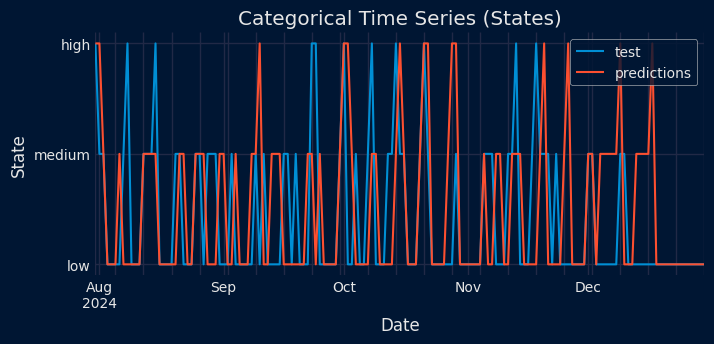

In [17]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[predictions.index, 'encoded_value'].plot(ax=ax, label='test')
predictions.assign(encoded_value=predictions['pred'].map(encode_mapping))['encoded_value'].plot(ax=ax, label='predictions')
y_ticks = list(encode_mapping.values())
y_labels = list(encode_mapping.keys())
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_title("Categorical Time Series (States)")
ax.set_xlabel("Date")
ax.set_ylabel("State")
ax.legend();

## Hyperparameter tuning

[Hyperparameter tuning](../user_guides/hyperparameter-tuning-and-lags-selection.html) for `ForecasterRecursiveClassifier` can be performed using the functions available in the `skforecast.model_selection` module, such as `grid_search_forecaster`, `random_search_forecaster` and `bayesian_search_forecaster`. These functions allow for systematic exploration of hyperparameter combinations to identify the best configuration for the forecaster based on specified evaluation metrics suitable for classification tasks.

When performing hyperparameter tuning, it is important to use a train-validation-test split approach. This involves dividing the dataset into three distinct subsets:

- Training set: Used to fit the model.
- Validation set: Used to tune the hyperparameters.
- Test set: Used to evaluate the model's performance.

This approach helps to prevent overfitting and ensures that the model generalizes well to unseen data.

In [18]:
# Train-validation-test split
# ==============================================================================
end_train = '2024-03-30'
end_val = '2024-07-30'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}"
    f"  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_val:])})"
)
print("")

Train dates      : 2023-01-01 00:00:00 --- 2024-03-30 00:00:00  (n=455)
Validation dates : 2024-03-30 00:00:00 --- 2024-07-30 00:00:00  (n=123)
Test dates       : 2024-07-30 00:00:00 --- 2024-12-30 00:00:00  (n=154)



In [19]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                regressor       = LGBMClassifier(random_state=123, verbose=-1),
                lags            = 15, # Placeholder, the value will be overwritten
                window_features = RollingFeaturesClassification(stats=['proportion'], window_sizes=[10])
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [3, 7, 14, 21]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }
    
    return search_space

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = end_train,
         refit              = False,
     )

results, best_trial = bayesian_search_forecaster(
                          forecaster    = forecaster,
                          y             = data.loc[:end_val, 'y'],
                          search_space  = search_space,
                          cv            = cv,
                          metric        = 'balanced_accuracy_score',
                          n_trials      = 20,
                          random_state  = 123,
                          return_best   = True,
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True,
                      )
results.head(4)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}
  Backtesting metric: 0.17988939165409754


,lags,params,balanced_accuracy_score,n_estimators,min_samples_leaf,max_features
0,"[1, 2, 3]","{'n_estimators': 20, 'min_samples_leaf': 1, 'm...",0.179889,20,1,log2
1,"[1, 2, 3]","{'n_estimators': 20, 'min_samples_leaf': 1, 'm...",0.179889,20,1,sqrt
2,"[1, 2, 3]","{'n_estimators': 20, 'min_samples_leaf': 1, 'm...",0.179889,20,1,log2
3,"[1, 2, 3]","{'n_estimators': 17, 'min_samples_leaf': 5, 'm...",0.210692,17,5,log2


In [20]:
# Best model
# ==============================================================================
forecaster

============================= 
ForecasterRecursiveClassifier 
============================= 
Classifier: LGBMClassifier 
Lags: [1 2 3] 
Window features: ['roll_proportion_10'] 
Window size: 10 
Series name: y 
Classes: ['high', 'low', 'medium'] 
Number of classes: 3 
Exogenous included: False 
Exogenous names: None 
Feature encoding: auto 
Transformer for exog: None 
Weight function included: False 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2024-07-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Classifier parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 20, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1,
    'min_samples_leaf': 1, 'max_features': 'log2'} 
fit_kwargs: {} 
Creation date: 2025-11-02 15:15:58 
Last fit date: 2025-11-02 15:16:01 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

In [21]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['y'],
                          cv         = cv,
                          metric     = 'balanced_accuracy_score'
                      )
display(metric)
predictions

  0%|          | 0/23 [00:00<?, ?it/s]

,balanced_accuracy_score
0,0.291684


,fold,pred,high_proba,low_proba,medium_proba
2024-03-31,0,medium,0.180394,0.123231,0.696375
2024-04-01,0,medium,0.182249,0.122065,0.695686
2024-04-02,0,medium,0.358463,0.082613,0.558924
2024-04-03,0,high,0.609439,0.083244,0.307317
2024-04-04,0,high,0.832901,0.049463,0.117636
...,...,...,...,...,...
2024-12-26,22,medium,0.079160,0.061959,0.858881
2024-12-27,22,medium,0.070666,0.094459,0.834875
2024-12-28,22,low,0.379732,0.501082,0.119186
2024-12-29,22,low,0.040682,0.906566,0.052752
